# Simulation and Noise Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../../')

We can set up a noise model, following the [Qiskit textbook](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html#Correcting-errors-in-qubits). We define our noise model to have equal chances of X and Z:

In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise_model(p_err):

    error_gate1 = pauli_error([("X", p_err), ("I", 1 - p_err)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "id")
    return noise_model

We set up a test harness to run through some examples:

In [4]:
import sys
import os

sys.path.insert(0, ".." + os.sep)
from benchmarking import TopologicalBenchmark, TopologicalAnalysis
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from topological_codes import RepetitionGraphDecoder
from topological_codes import RepetitionQubit
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
from tqdm import tqdm

import multiprocessing as mp

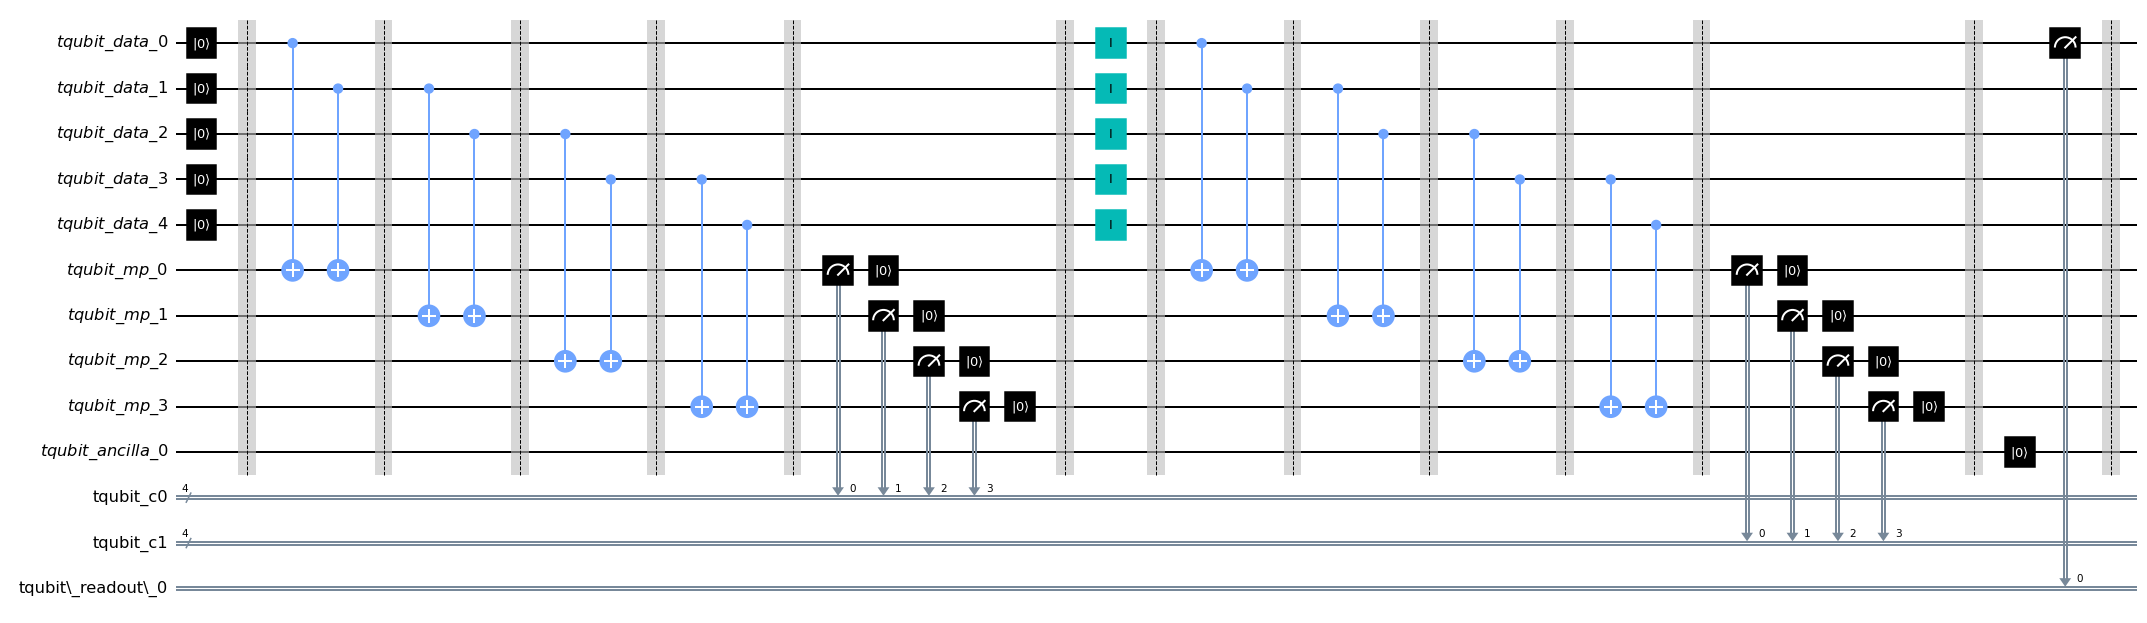

In [5]:
d = 5
T = 1

qubit = RepetitionQubit({'d':d})
qubit.logical_plus_z_reset()
qubit.stabilize()
qubit.identity_data()
qubit.stabilize()
qubit.readout_z()
qubit.draw(output='mpl', fold=50)

In [13]:
tool = TopologicalBenchmark(
    decoder=RepetitionGraphDecoder({"d":d, "T":T}),
    circ=qubit.circ,
    noise_model_func=get_noise_model,
    correct_logical_value = 0
)

print("\nSIMULATE: (d={},T={})\n".format(tool.decoder.params["d"], tool.decoder.params["T"]))
physical_error_rates = [.1*i+.05 for i in range(10)]
tool.sweep(physical_error_rates=physical_error_rates)
print("Done!")

Done with noise: 0.9500000000000001:  10%|█         | 1/10 [00:00<00:01,  8.72it/s]


SIMULATE: (d=5,T=1)



Done with noise: 0.05: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]              

Done!


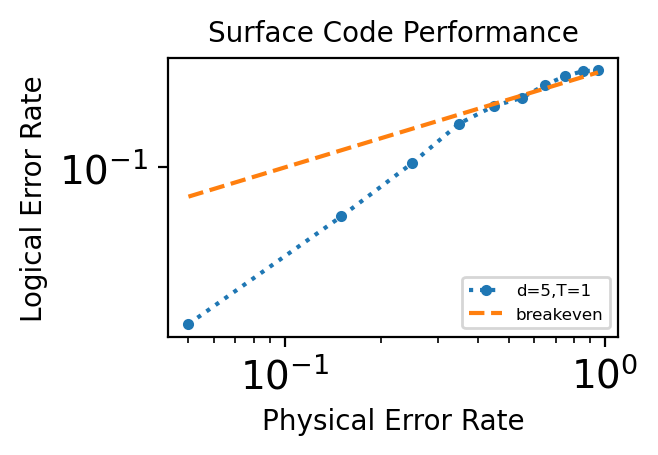

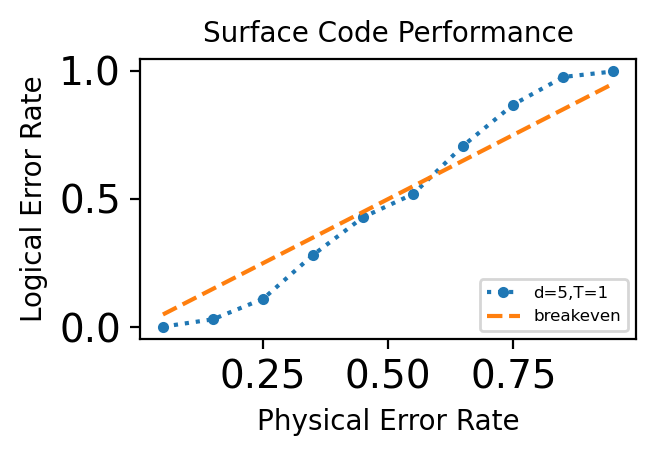

In [14]:
import matplotlib.pyplot as plt
import numpy as np

analysis = TopologicalAnalysis()
for log_plot in [True, False]:
    fig = plt.figure(figsize=(3.5, 2.5), dpi=200)
    ax = fig.subplots()
    analysis.params["d"] = int(tool.decoder.params["d"])
    analysis.params["T"] = int(tool.decoder.params["T"])
    analysis.data["physical_error_rates"] = tool.data["physical_error_rates"]
    analysis.data["logical_error_rates"] = tool.data["logical_error_rates"]
    analysis.plot(
        fig=fig,
        ax=ax,
        label="d={},T={}".format(tool.decoder.params["d"], tool.decoder.params["T"]),
        log=log_plot,
    )
    plt.plot(
        tool.data["physical_error_rates"],
        tool.data["physical_error_rates"],
        "--",
        label="breakeven",
    )
    plt.legend(loc="lower right", prop={"size": 6})
    ax.set_xlabel("Physical Error Rate", size=10)
    ax.set_ylabel("Logical Error Rate", size=10)
    ax.set_title("Surface Code Performance", size=10)
    fig.tight_layout()
    plt.show()